# Checking fit of model (PPC) and Validating MCMC model (using LOO and WAIC)

## Posterior Predictive Checks (PPC)

First, we will look into way to check how well model fits the data using [Posterior Predictive Checks \(PPC\)](https://docs.pymc.io/notebooks/posterior_predictive.html#Posterior-Predictive-Checks)

From documentation of the PPC of pymc3 (_link above_):
> *PPCs are an excellent tool for revising models, simplifying or expanding the current model as one examines how well it fits the data.*

> *Elaborating slightly, one can say that PPCs analyze the degree to which data generated from the model deviate from data generated from the true distribution. So often you will want to know if, for example, your posterior distribution is approximating your underlying distribution. The visualization aspect of this model evaluation method is also great for a ‘sense check’ or explaining your model to others and getting criticism.*

In [1]:
import numpy as np
import pandas as pd
import AgentClass
import const
import random
import networkx as nx
from config import num_agents,number_of_bits
from scipy import stats
from collections import defaultdict
import json
import utilities

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib
import seaborn as sns

import pymc3 as pm

import arviz as az

from IPython.display import display_html

In [2]:
sns.set(style='darkgrid', rc={'figure.figsize':(10,6)}, font_scale=1.25)

In [3]:
def get_tau_distr():
    lower = 0
    upper = 1
    mu = 0.5
    sigma = 0.1
    N = 1000

    samples = stats.truncnorm.rvs(
          (lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N)

    return samples

In [4]:
def create_environment():
    list_agents = []
    tau_distr = get_tau_distr()

    for i in range(num_agents):
        in_state = np.random.randint(2, size=number_of_bits).tolist()
        a = AgentClass.Agent(name='agent{}'.format(i), tau=random.choice(tau_distr), initial_state=in_state)
        list_agents.append(a)

    # create network
    G = nx.newman_watts_strogatz_graph(num_agents, 5, 0.5, seed= 0)
#    nx.draw(G, with_labels=True, font_weight='bold') # to draw agents
    df = nx.to_pandas_adjacency(G, dtype=int)

    tmp_edges = df.apply(lambda row: row.to_numpy().nonzero()).to_dict()
    edges = {k: v[0].tolist() for k, v in tmp_edges.items()}

    # make random connections with agents
    for k, v in edges.items():
        for ngh in v:
            list_agents[k].add_neighbors(list_agents[ngh])

    return list_agents

In [5]:
def get_network_df(list_agents):
    network_df = pd.DataFrame({'Agent Name':[], 'Neighbors':[]})
    for agt in list_agents:
        neighbors = agt.get_neighbors_name()
        network_df = network_df.append({'Agent Name':agt.name,
                                        'Neighbors':neighbors}, ignore_index=True)
    return network_df

In [6]:
def run_simulation(alpha, const:const.Constants, list_agents, end_time):
    d = []
    generations = 0
    for t in range(end_time):
        # compute next state for all agents
        for agt in list_agents:
            agt.update_knowledge(alpha, const.coh_transition_matrix, const.bit_matrix)

        # keep record of current record and all other values
        for agt in list_agents:
            row = {'Agent_Name':agt.name,
                   'Agent_Dissonance':np.array(agt.dissonance_lst),
                   'Time':t,
                   'probs':agt.soc_probs,
                   'Current_Knowledge_State':agt.knowledge_state,
                   'Current': utilities.bool2int(agt.knowledge_state),
                   'Next': utilities.bool2int(agt.next_state),
                   'Next_Knowledge_State':agt.next_state}

            d.append(row)

        # now update all agents next state with computed next state
        for agt in list_agents:
            agt.knowledge_state = agt.next_state
            agt.next_state = None
            agt.dissonance_lst = None

        generations+=1
#         if generations%10 == 0:
#             print("alpha = {}; {} generations".format(alpha,generations))

    return pd.DataFrame(d)

In [7]:
def display_side_by_side(*args):
    """This function is only for viewing two dataframe side by side
    It helps to compare how the distributions are in original and sampled traces for now
    Reference: https://stackoverflow.com/a/44923103/5916727"""
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

## Running simulation for generating data
> alpha = 0.1 <br>
> number of agents were set to 100 in config file <br>
> experiment time is only 1 currently, we may want to check with different random seed <br>
> coherence matrix is created with alpha_d value set to **alpha_d $\rightarrow$ .001** this will effect results coherence matrix <br>
> each agent moves for 100 steps starting from t=0 $\rightarrow$ t=99

In [8]:
### This cell is for generating the dataset
# constants intialization
end_simulation_time = 100
alphas = [0] 
exp_times = 1

# first create environment
agents_list = create_environment()

# get network of the agents
agent_network_df = get_network_df(agents_list)

# for saving the network of agents
# agent_network_df.to_json('test_network.json',orient='records', lines=True)

for i in range(exp_times):

    random.seed(i) # if later when we want to run with multiple random seed value
    constants = const.Constants()
    # generating coherence matrix
    coherence_matrix = constants.get_coh_tx_matrix().tolist()

    # run simulation
    for alpha in alphas:

        record_df = run_simulation(alpha, constants, agents_list, end_simulation_time)

Viewing how coherence matrix that generated data:

In [9]:
display(pd.DataFrame(coherence_matrix))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.423396,0.576604,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
4,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
7,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.011841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.988159
9,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Once we have run the simulation, we have results in "record_df".
We can look at distribution of state transitions as below: 

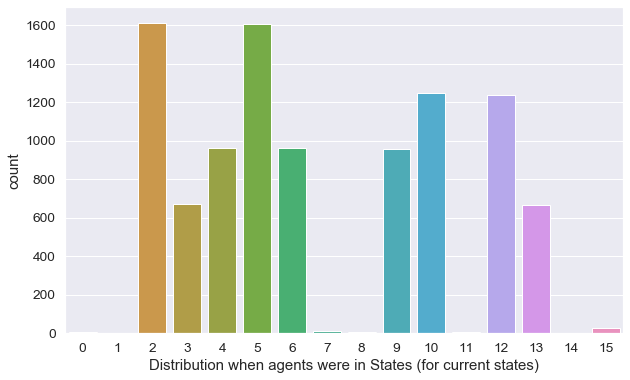

In [10]:
sns.countplot(x='Current', data=record_df);
plt.xlabel('Distribution when agents were in States (for current states)');

We will select one of the state above for checking distributions and MCMC modeling.
> stored in *'sel_state'* variable below

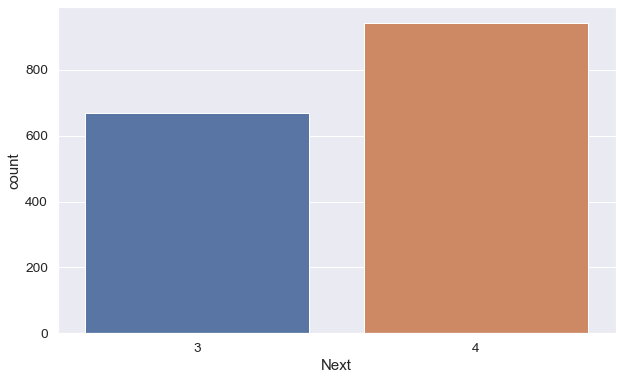

In [12]:
sel_state = 2

data = record_df[record_df['Current']==sel_state]
sns.countplot(x='Next', data=data);

# Using pyMC3

Using pymc3 MCMC sampling to estimate parameters, for now we only estimate probability of state transitions given a selected state

In [14]:
soc_probs = np.asarray(data['probs'].tolist()) # for now using final result of soc_probs this has to change to handle "tau" of agents
y = np.asarray(data['Next'].tolist()) # this is the next state values for each data from simulations
k = 2**number_of_bits # this is number of possible states 
#Try 1-hot encoding
y_hot = np.eye(k)[y] # we changed above state values to one hot encoding

alpha = alphas[0] # for now not estimating alpha values, instead using same as used in generation of data

Running MCMC with default No-U-Turn Sampler 
> For details: [The No-U-Turn Sampler: Adaptively Setting Path Lengths in Hamiltonian Monte Carlo](https://arxiv.org/pdf/1111.4246.pdf)

In [15]:
with pm.Model() as model:
    
    # initializes the Dirichlet distribution with a uniform prior:
    a = np.ones(k) 
    
    theta = pm.Dirichlet("theta", a=a, shape=k)
    tmp = alpha*soc_probs + (1-alpha)*theta
       
    results = pm.Multinomial("results", n=1, p=tmp, observed=y_hot, shape=k)

C:\Users\niraj\AppData\Local\Continuum\anaconda3\envs\probabilistic\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


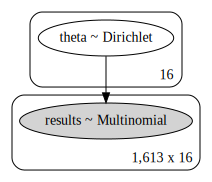

In [16]:
pm.model_to_graphviz(model)

pm.sample from pymc3 draws samples from the posterior using the given step methods.
> For details on parameters [pymc3 reference](https://docs.pymc.io/api/inference.html)

In [17]:
with model:
     trace = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:28<00:00, 131.53draws/s]


Comparing side by side how well did MCMC did with mean values of samples from trace of MCMC

In [20]:
trace_df = pm.summary(trace).round(4)[['mean']]
trace_df.columns = ['trace Mean']
coh_df = pd.DataFrame(pd.DataFrame(coherence_matrix).iloc[sel_state])
coh_df.columns = ['Coh_matrix Mean']

C:\Users\niraj\AppData\Local\Continuum\anaconda3\envs\probabilistic\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


In [21]:
display_side_by_side(coh_df, trace_df)

,Coh_matrix Mean
0,0.000000
1,0.000000
2,0.000000
3,0.423396
4,0.576604
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000


## Using Post Predictive Check

Below function will randomly draw 500 samples of parameters from the trace. Then, for each sample, it will draw 4,463 random numbers from a normal distribution specified by the values of mu and std in that sample. 
> [pymc3 documentation reference](https://docs.pymc.io/notebooks/posterior_predictive.html)

Then, we will look into visualization if model can reproduce the patterns observed in the real data. For example, how close are the inferred means to the actual sample mean. In our case we will compare how close the model is with mean from coherence matrix for that selected state

In [22]:
ppc = pm.sample_posterior_predictive(trace, samples=500, model=model)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 232.74it/s]


In [23]:
np.asarray(ppc['results']).shape

(500, 1613, 16)

In our original coherence matrix, for the given state we only have two non-zero values, others were zero. Below we can view how far the distribution deviates from the original mean from coherence matrix.

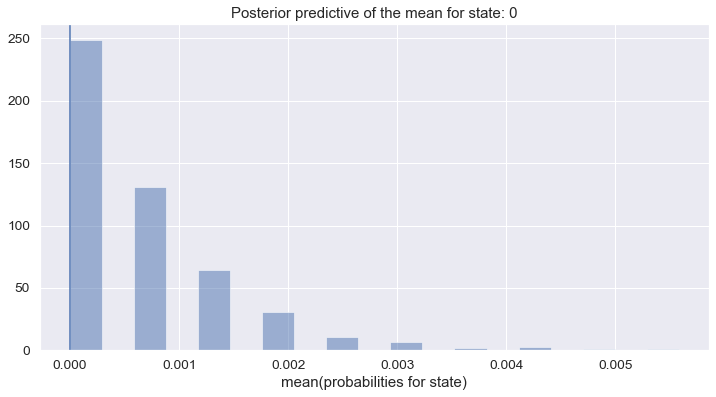

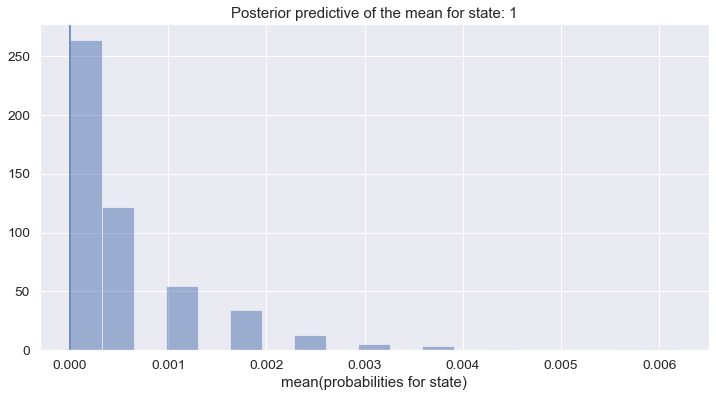

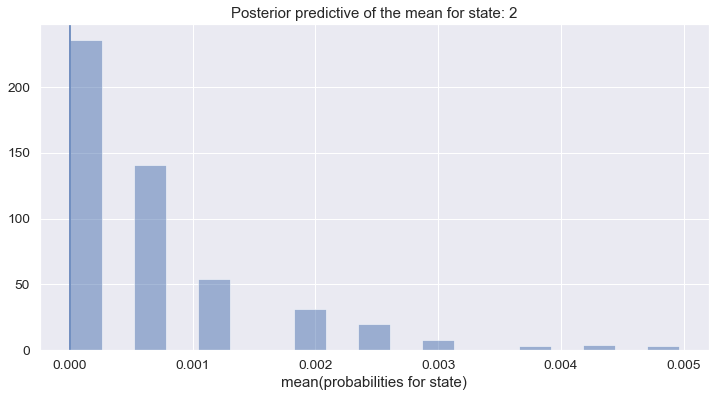

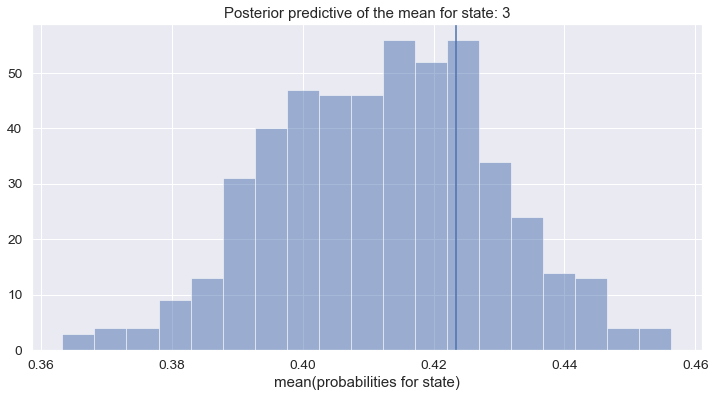

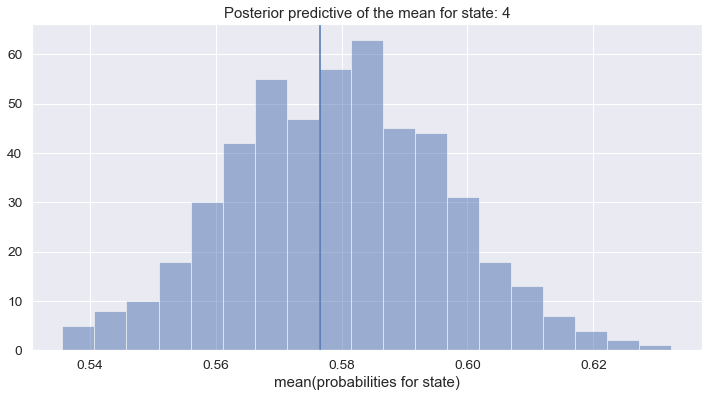

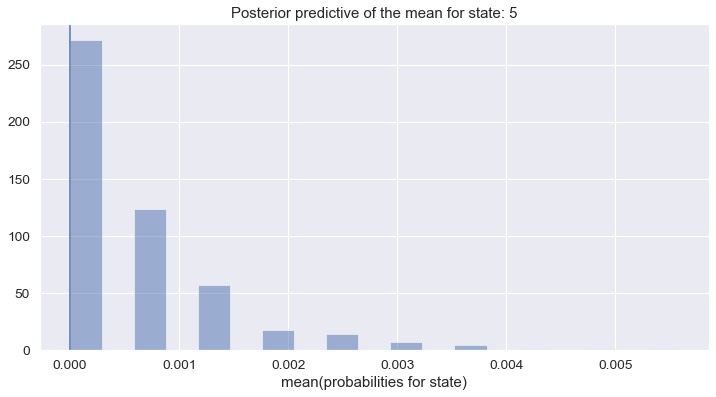

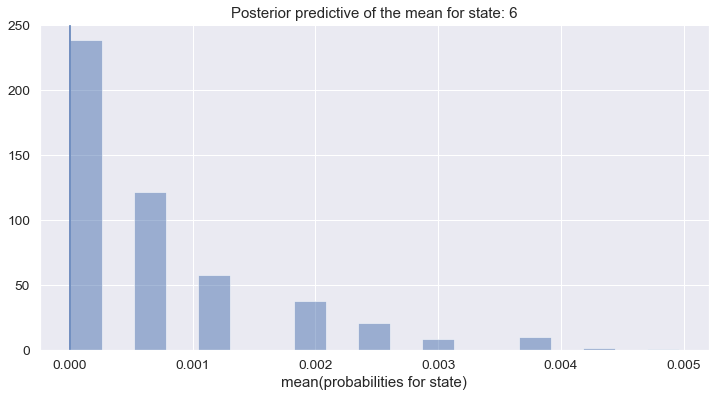

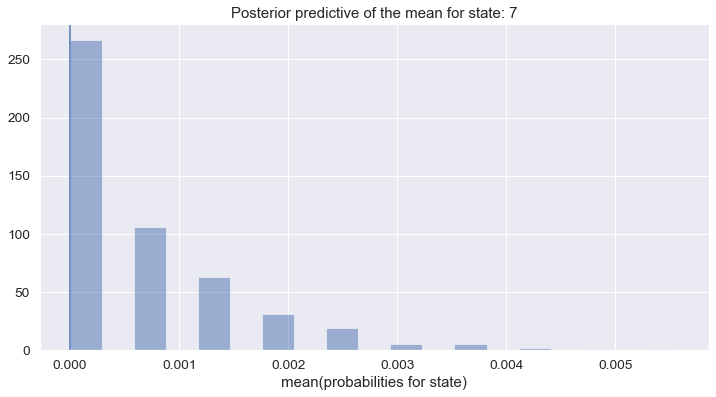

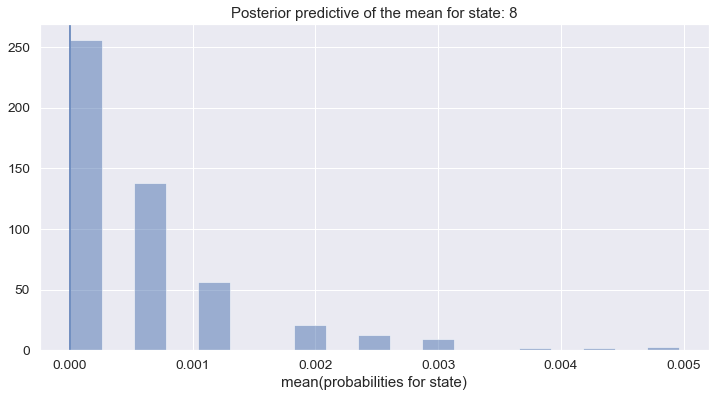

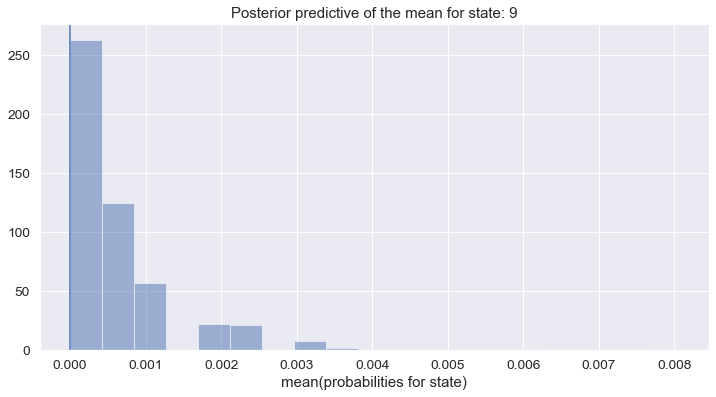

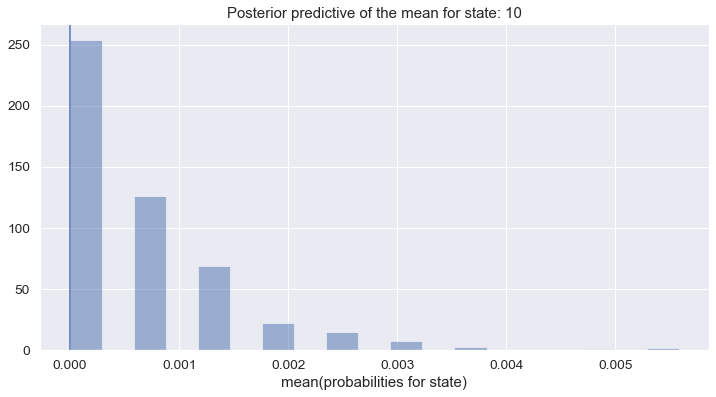

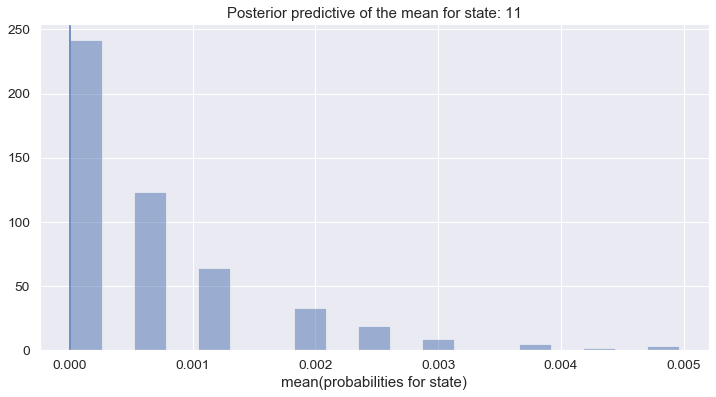

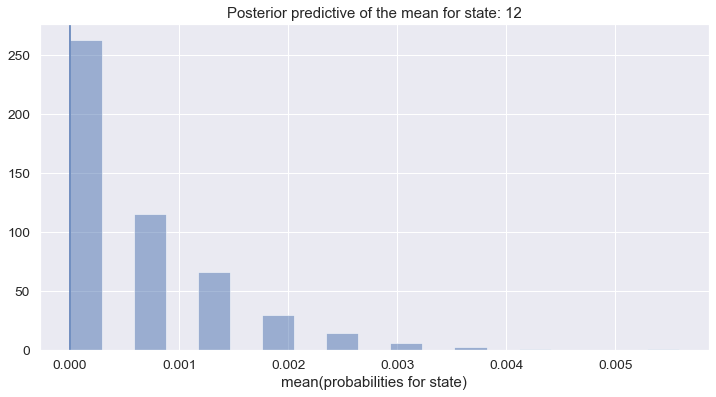

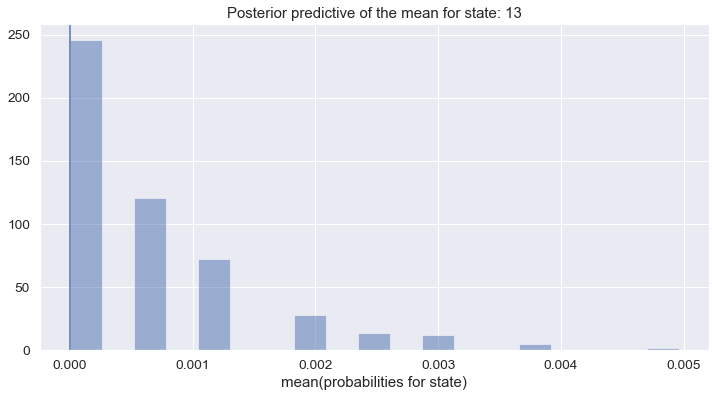

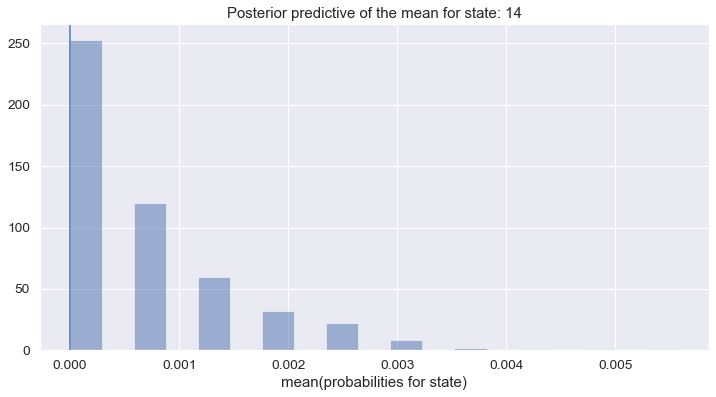

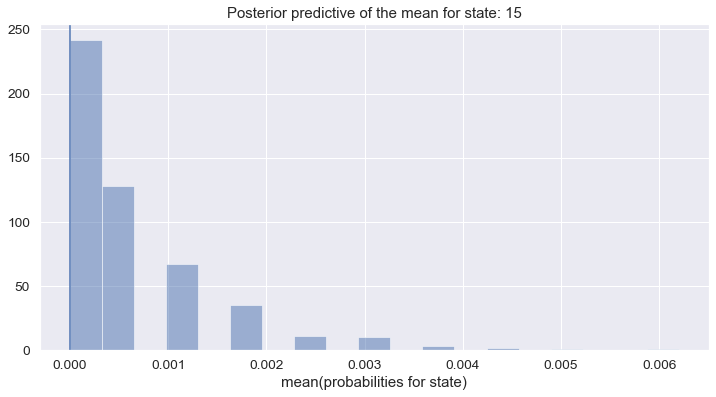

In [24]:
for i in range(16):
    tmp = ppc['results'][:, :, i]
    _, ax = plt.subplots(figsize=(12, 6))
    ax.hist([n.mean() for n in tmp], bins=19, alpha=0.5)
    ax.axvline(coh_df.iloc[i].values[0])
    
    ax.set(title='Posterior predictive of the mean for state: {}'.format(i), xlabel='mean(probabilities for state)');

In [25]:
ppc_df = pd.DataFrame(ppc['results'].mean(axis=0).mean(axis=0))
ppc_df.columns = ['Sampled mean']

In [26]:
display_side_by_side(coh_df, trace_df, ppc_df)

,Coh_matrix Mean
0,0.000000
1,0.000000
2,0.000000
3,0.423396
4,0.576604
5,0.000000
6,0.000000
7,0.000000
8,0.000000
9,0.000000


From above distributions and PPC results it seems the model did fit reasonably well for the data. Now we can check for the predictability accuracy of the model.

# Model Evaluation

**From the article: [Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC](https://arxiv.org/pdf/1507.04544.pdf)**


After fitting a Bayesian model we want to know it's out-of-sample predictive accuracy which can be evaluated with two approaches that are:

1. **Cross Validation:**
>The article consider computations using the log-likelihood evaluated at the usual posterior simulations of the parameters.
<u>**Leave One Out (LOO)**</u> is cross-validation approach that can be computationally expensive as it will require to fit model in n-1 samples and predict on remaining one sample iteratively for each sample. The paper proposes Pareto smoothed importance (PSIS),that provides more accurate and reliable estimate by fitting Pareto distribution.


2. **Information criteria**
>WAIC (the widely applicable or Watanable-Akaike information criterion;2010) is based on deviance information criterion (DIC).

The paper states:
> *Although WAIC is asympotically equal to LOO, we demonstrate that PSIS-LOO is more robust in the finite case with weak priors or influential observations.*

In [27]:
ar_loo2 = az.loo(trace, pointwise=True, scale="log")

In [28]:
ar_loo2

Computed from 4000 by 1613 log-likelihood matrix

         Estimate       SE
elpd_loo -1109.77     6.78
p_loo        0.99        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1613  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [32]:
pd.DataFrame(ar_loo2)

,0
loo,-1109.77
loo_se,6.78166
p_loo,0.985362
n_samples,4000
n_data_points,1613
warning,False
loo_i,[[<xarray.DataArray 'loo_i' ()>\narray(-0.5456...
pareto_k,[[<xarray.DataArray 'pareto_shape' ()>\narray(...
loo_scale,log


In [29]:
pooled_loo = pm.loo(trace, model, pointwise=True, progressbar=True)

pooled_loo.LOO

4000it [00:02, 1351.31it/s]


2219.548551028707

Bayesian LOO estimate of out-of-sample predictive fit is:<br>
$elpd_{loo} = \sum^{n}_{i=1}{\log p(y_i|y_{-i})}$ <br>
<br>
where, <b>elpd</b> $\rightarrow$ expected log pointwise predictive density
 $y_1, ......, y_n$ are data <br>
 $\theta$ are parameters to model data i.e. $p(y|\theta) = \prod_{i=1}^{n}p(y_i|\theta)$ <br>
and $p(y_i|y_{-i}) = \int p(y_{i}|\theta)p(\theta|y_{-i})d\theta$

However, as stated above, LOO uses psis for effective and robustness which is given by: <br>
$\widehat{elpd}_{psis-loo}$ = $\sum ^{n}_{i=1} \log (\frac{\sum_{s=1}^{S} \omega^{s}_{i}\ p(y_i|\theta^s)}{\sum_{s=1}^{S}\ \omega_{i}^{s}})$ <br>

For more details about above equation refer to the paper [Practical Bayesian model evaluation using leave-one-out cross-validation and WAIC](https://arxiv.org/pdf/1507.04544.pdf)

So, lesser the LOO or WAIC value the better if scale is deviance (default). Or if the scale is set to log then, more towards 0 is better.

In [30]:
pooled_waic = pm.waic(trace, model, pointwise=True, progressbar=True)

pooled_waic.WAIC

4000it [00:02, 1354.95it/s]


2219.548547177669

Looking back on states distribution for next state given current state is 2 we have:

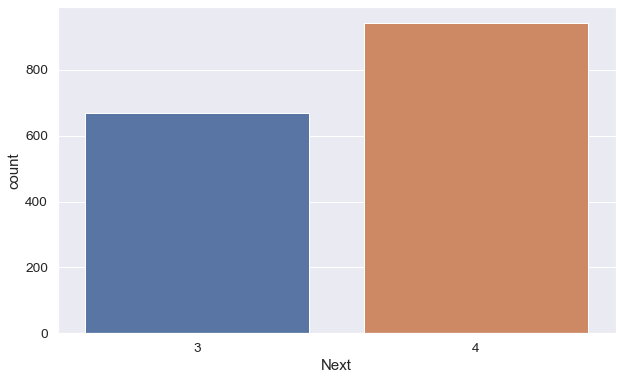

In [33]:
sns.countplot(x='Next', data=data);

from coherence matrix:

In [34]:
coh_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Coh_matrix Mean,0.0,0.0,0.0,0.423396,0.576604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


it would be difficult to build good predictive model since, there is almost equal uncertainity for next state given a state is 2.

So, we look into some other states and see how this varies:

In [36]:
pd.DataFrame(coherence_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.423396,0.576604,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
4,0.0,0.0,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
7,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.011841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.988159
9,0.0,0.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Given state 10 it can go to state 12 and given 12 it can go to 10 from observing coherence matrix. Let's select state = 10 and view next state transitions given current 10 as a current state. 

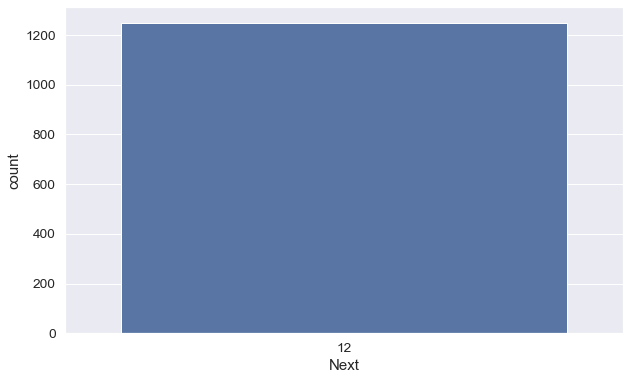

In [37]:
sel_state = 10

data = record_df[record_df['Current']==sel_state]
sns.countplot(x='Next', data=data);

as expected the data shows 12 which means following previous argument on predictibility given the model fits well it should have good predictibility.

Building MCMC model again and checking model fitting:

In [38]:
soc_probs = np.asarray(data['probs'].tolist()) # for now using final result of soc_probs this has to change to handle "tau" of agents
y = np.asarray(data['Next'].tolist()) # this is the next state values for each data from simulations
k = 2**number_of_bits # this is number of possible states 
#Try 1-hot encoding
y_hot = np.eye(k)[y] # we changed above state values to one hot encoding

alpha = alphas[0] # for now not estimating alpha values, instead using same as used in generation of data

with pm.Model() as model:
    
    # initializes the Dirichlet distribution with a uniform prior:
    a = np.ones(k) 
    
    theta = pm.Dirichlet("theta", a=a, shape=k)
    tmp = alpha*soc_probs + (1-alpha)*theta
       
    results = pm.Multinomial("results", n=1, p=tmp, observed=y_hot, shape=k)
    
pm.model_to_graphviz(model)

with model:
     trace = pm.sample(draws=1000)

C:\Users\niraj\AppData\Local\Continuum\anaconda3\envs\probabilistic\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:18<00:00, 316.83draws/s]


In [39]:
ppc = pm.sample_posterior_predictive(trace, samples=500, model=model)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 251.04it/s]


In [43]:
trace_df = pm.summary(trace).round(4)[['mean']]
trace_df.columns = ['trace Mean']
coh_df = pd.DataFrame(pd.DataFrame(coherence_matrix).iloc[sel_state])
coh_df.columns = ['Coh_matrix Mean']
ppc_df = pd.DataFrame(ppc['results'].mean(axis=0).mean(axis=0))
ppc_df.columns = ['Sampled mean']
display_side_by_side(coh_df, trace_df, ppc_df)

,Coh_matrix Mean
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0


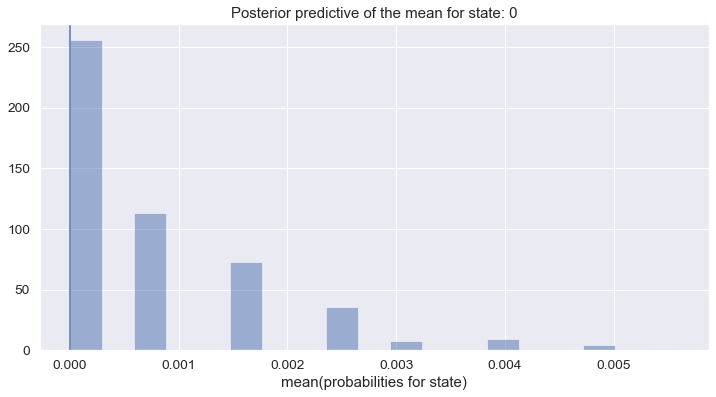

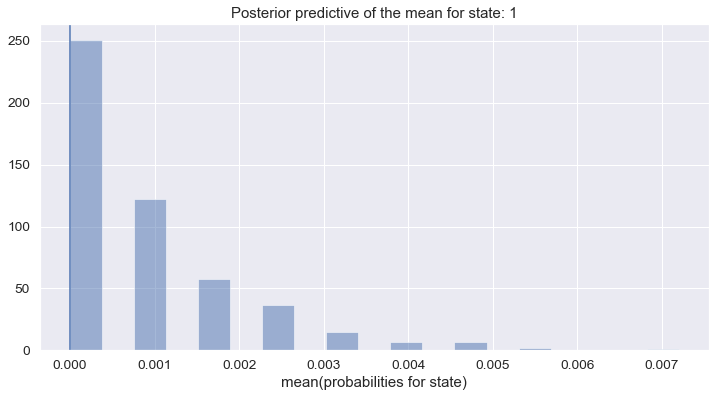

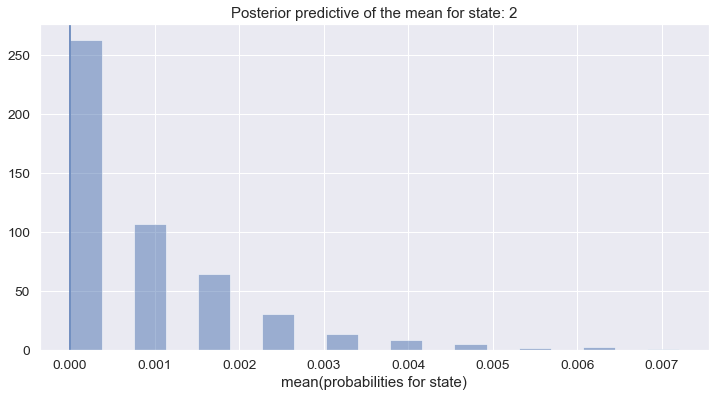

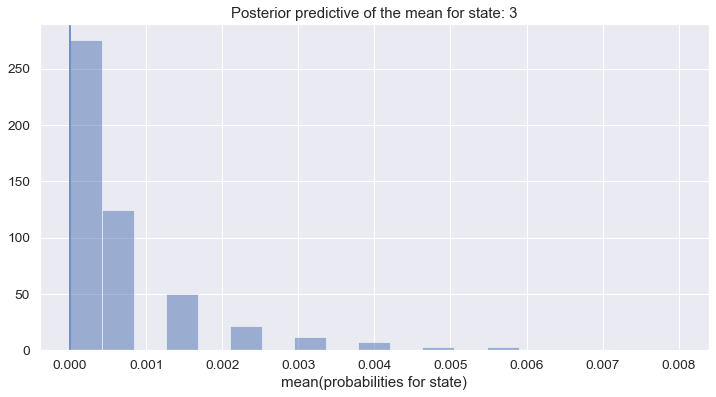

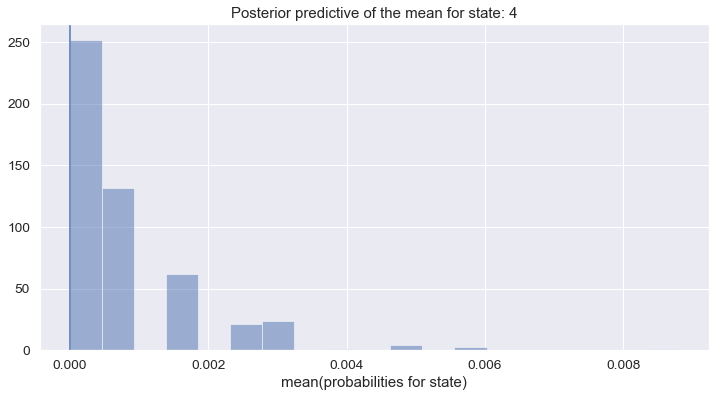

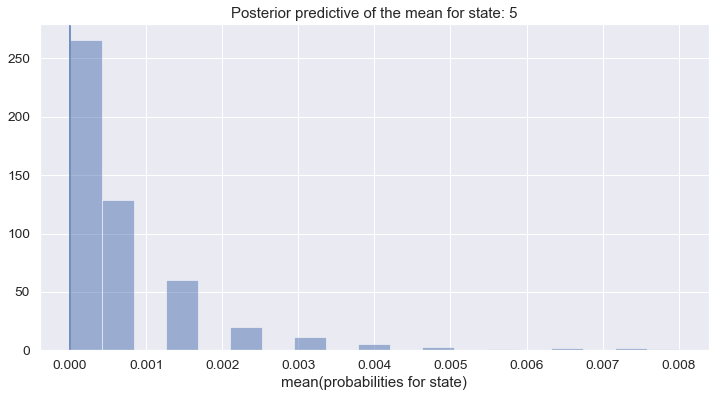

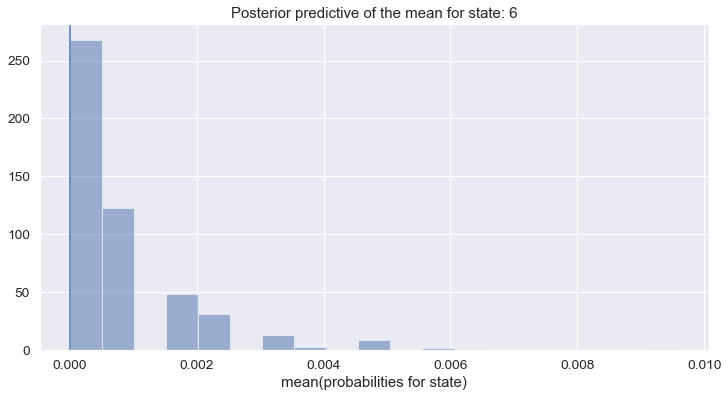

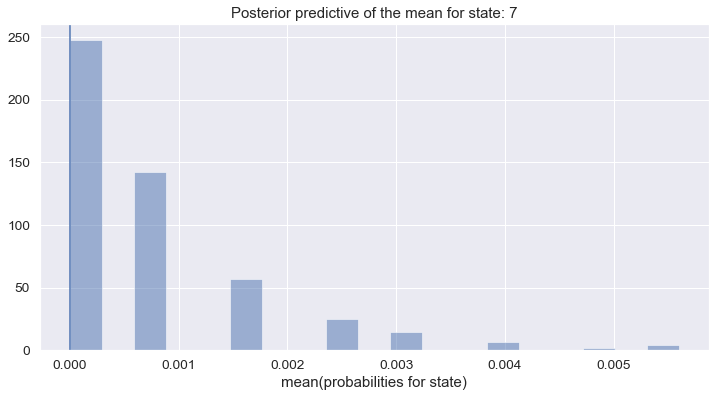

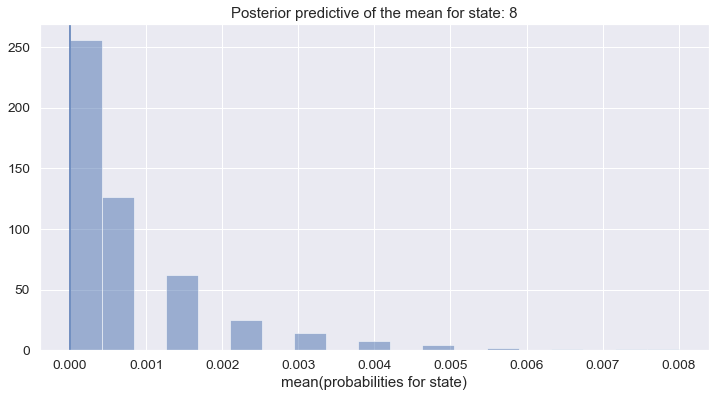

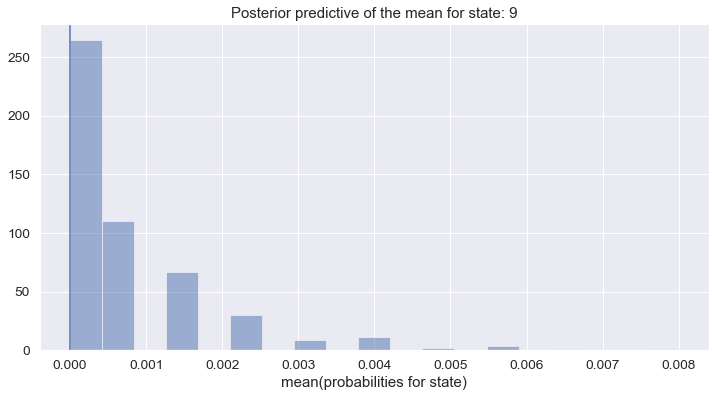

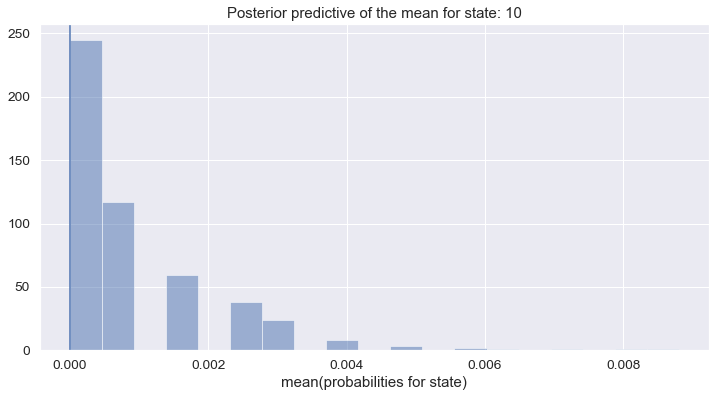

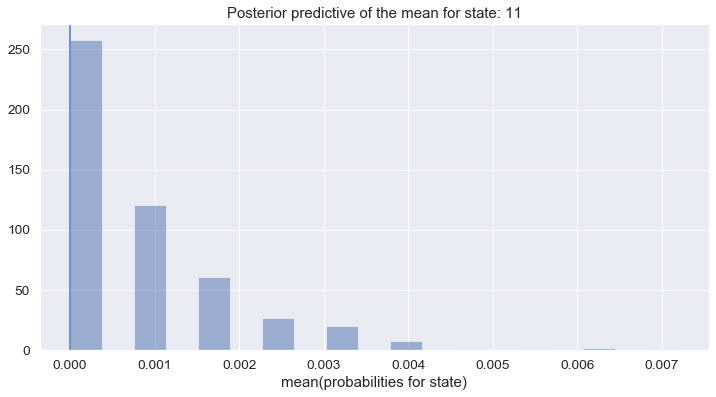

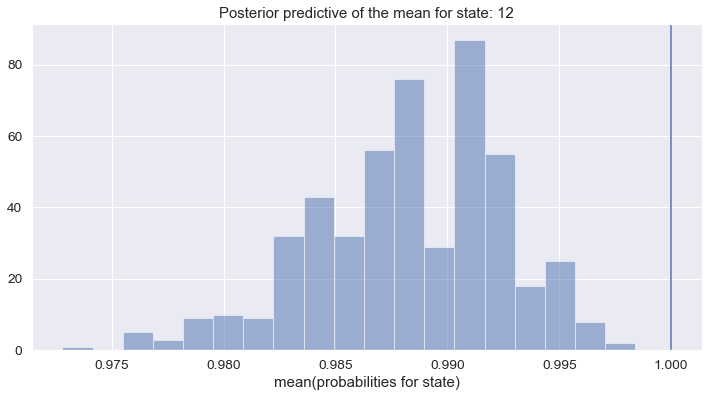

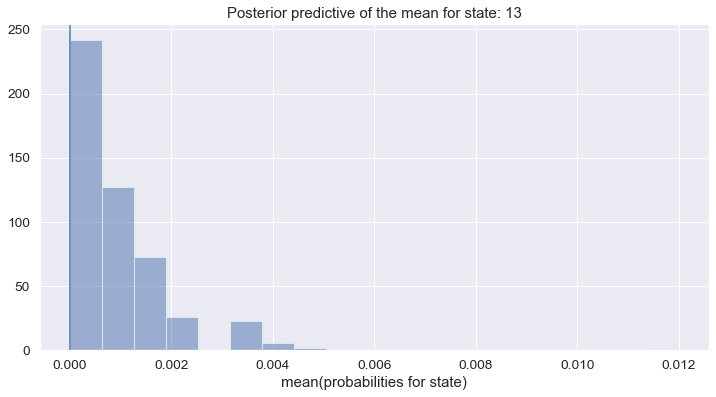

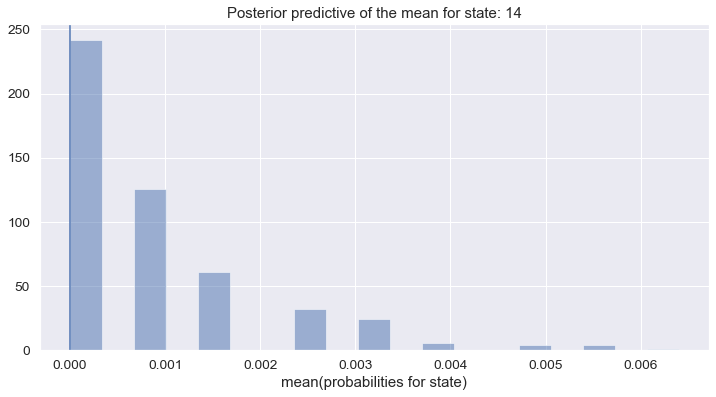

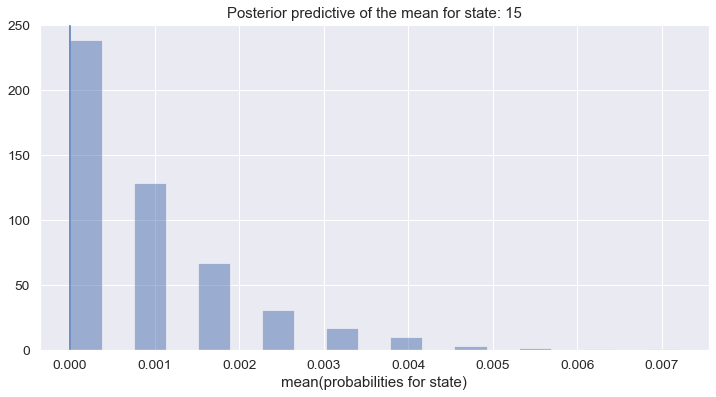

In [44]:
for i in range(16):
    tmp = ppc['results'][:, :, i]
    _, ax = plt.subplots(figsize=(12, 6))
    ax.hist([n.mean() for n in tmp], bins=19, alpha=0.5)
    ax.axvline(coh_df.iloc[i].values[0])
    
    ax.set(title='Posterior predictive of the mean for state: {}'.format(i), xlabel='mean(probabilities for state)');

In [45]:
ar_loo2 = az.loo(trace, pointwise=True, scale="log")
ar_loo2

Computed from 4000 by 1250 log-likelihood matrix

         Estimate       SE
elpd_loo   -14.94     0.00
p_loo        0.01        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1250  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

we can compare previous $elpd_{loo}$ = -1109.77 to $-14.94$ which means accuracy is much better.

We will look at how this value changes when there are multiple states of close higher probabilities. For this we will change the alpha_d value in config.py to greater value and recreate the coherence matrix and run similar analysis as above.

**NOTE**: Restarting Kernel and re-running all the functions and importing packages will be required. **But** to keep the above analysis we do not re-run those cells.

alpha_d $\rightarrow$ 0.3

In [8]:
### This cell is for generating the dataset
# constants intialization
end_simulation_time = 100
alphas = [0] 
exp_times = 1

# first create environment
agents_list = create_environment()

# get network of the agents
agent_network_df = get_network_df(agents_list)

# for saving the network of agents
# agent_network_df.to_json('test_network.json',orient='records', lines=True)

for i in range(exp_times):

    random.seed(i) # if later when we want to run with multiple random seed value
    constants = const.Constants()
    # generating coherence matrix
    coherence_matrix = constants.get_coh_tx_matrix().tolist()

    # run simulation
    for alpha in alphas:

        record_df = run_simulation(alpha, constants, agents_list, end_simulation_time)

In [9]:
pd.DataFrame(coherence_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.024091,0.032931,0.010166,0.011324,0.087995,0.027022,0.000000,0.000000,0.081320,0.676142,0.013519,0.000000,0.000000,0.020367,0.002116,0.013006
1,0.000000,0.047287,0.448659,0.008024,0.062892,0.001345,0.005188,0.037333,0.001313,0.058699,0.019096,0.000000,0.001073,0.144016,0.161469,0.003606
2,0.008046,0.010199,0.000000,0.069956,0.073876,0.010262,0.000000,0.007452,0.127137,0.168388,0.004499,0.080985,0.003129,0.031768,0.141193,0.263109
3,0.129003,0.129708,0.047921,0.313801,0.007956,0.000000,0.034847,0.027967,0.000000,0.021354,0.021903,0.033448,0.148294,0.008733,0.075067,0.000000
4,0.044498,0.000000,0.000000,0.000000,0.074130,0.006825,0.041035,0.046248,0.472612,0.000000,0.000000,0.068223,0.003942,0.000000,0.021843,0.220644
5,0.068810,0.194667,0.025616,0.002032,0.204289,0.003958,0.000000,0.011333,0.021484,0.000000,0.151996,0.069216,0.140166,0.000000,0.012360,0.094073
6,0.040673,0.002535,0.000000,0.372330,0.001978,0.001009,0.007201,0.002663,0.153582,0.021210,0.063040,0.028516,0.000000,0.006078,0.081103,0.218081
7,0.020004,0.001258,0.000000,0.038097,0.002123,0.000000,0.531417,0.003901,0.001106,0.258464,0.031116,0.002420,0.004261,0.014119,0.005199,0.086513
8,0.017772,0.000000,0.536924,0.195566,0.004261,0.008323,0.000000,0.000000,0.044201,0.009264,0.130448,0.002124,0.000000,0.001916,0.046712,0.002489
9,0.001290,0.000000,0.175681,0.004269,0.065149,0.014049,0.043026,0.061506,0.023079,0.048010,0.005350,0.016999,0.001437,0.050325,0.358461,0.131368


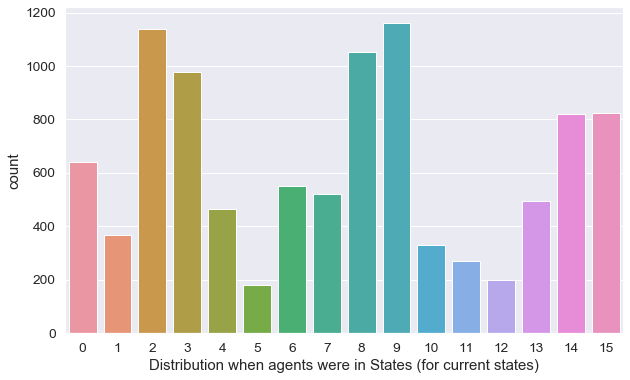

In [10]:
sns.countplot(x='Current', data=record_df);
plt.xlabel('Distribution when agents were in States (for current states)');

From above observations and coherence matrix, we will select when 2 is current state. 

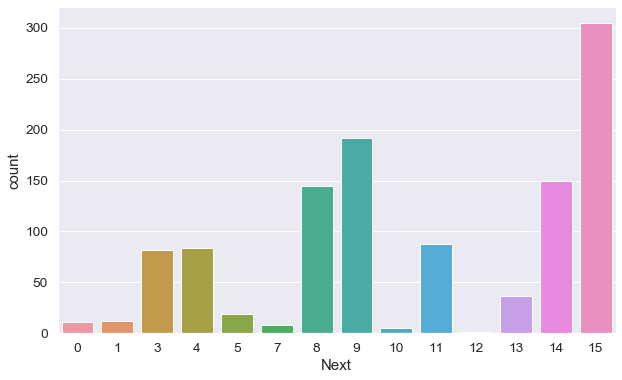

In [11]:
sel_state = 2

data = record_df[record_df['Current']==sel_state]
sns.countplot(x='Next', data=data);

Building MCMC model again and checking model fitting:

In [12]:
soc_probs = np.asarray(data['probs'].tolist()) # for now using final result of soc_probs this has to change to handle "tau" of agents
y = np.asarray(data['Next'].tolist()) # this is the next state values for each data from simulations
k = 2**number_of_bits # this is number of possible states 
#Try 1-hot encoding
y_hot = np.eye(k)[y] # we changed above state values to one hot encoding

alpha = alphas[0] # for now not estimating alpha values, instead using same as used in generation of data

with pm.Model() as model:
    
    # initializes the Dirichlet distribution with a uniform prior:
    a = np.ones(k) 
    
    theta = pm.Dirichlet("theta", a=a, shape=k)
    tmp = alpha*soc_probs + (1-alpha)*theta
       
    results = pm.Multinomial("results", n=1, p=tmp, observed=y_hot, shape=k)

C:\Users\niraj\AppData\Local\Continuum\anaconda3\envs\probabilistic\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


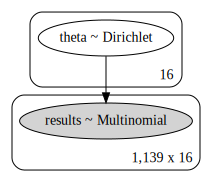

In [13]:
pm.model_to_graphviz(model)

In [14]:
with model:
     trace = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:16<00:00, 366.19draws/s]


Checking the mean of the true, model, and samples. 

In [17]:
ppc = pm.sample_posterior_predictive(trace, samples=500, model=model)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 270.43it/s]


In [18]:
trace_df = pm.summary(trace).round(4)[['mean']]
trace_df.columns = ['trace Mean']
coh_df = pd.DataFrame(pd.DataFrame(coherence_matrix).iloc[sel_state])
coh_df.columns = ['Coh_matrix Mean']
ppc_df = pd.DataFrame(ppc['results'].mean(axis=0).mean(axis=0))
ppc_df.columns = ['Sampled mean']
display_side_by_side(coh_df, trace_df, ppc_df)

C:\Users\niraj\AppData\Local\Continuum\anaconda3\envs\probabilistic\lib\site-packages\pymc3\stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,Coh_matrix Mean
0,0.008046
1,0.010199
2,0.000000
3,0.069956
4,0.073876
5,0.010262
6,0.000000
7,0.007452
8,0.127137
9,0.168388


In the figures below, the green lines are from mean of true dataset, yellow from MCMC models to see how much off they are from distribution of samples.

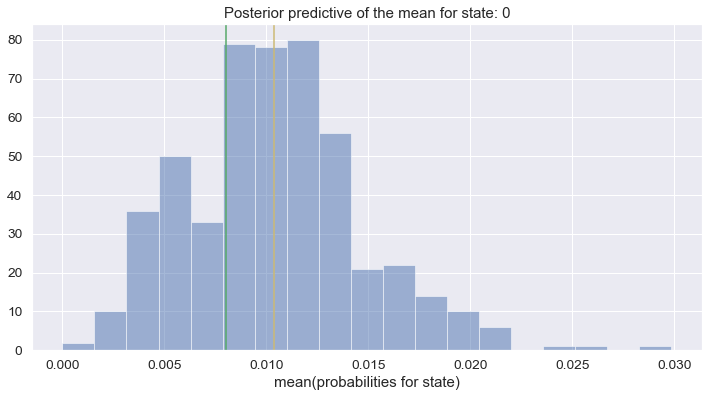

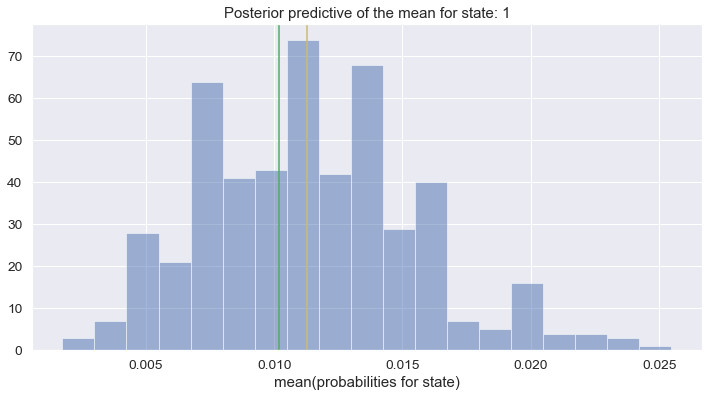

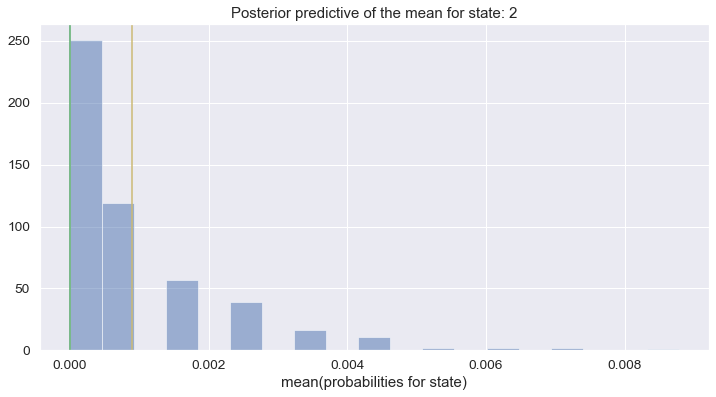

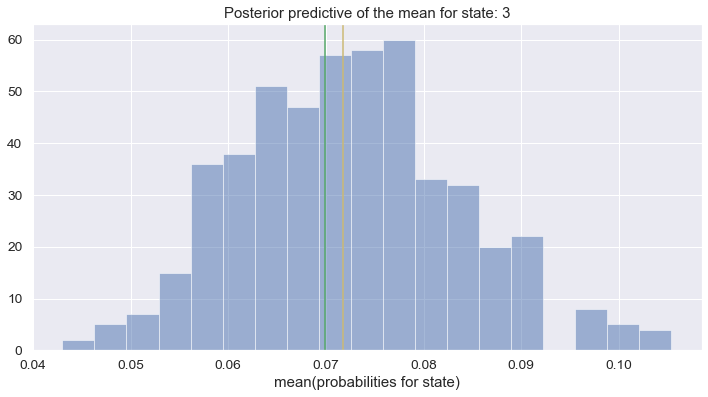

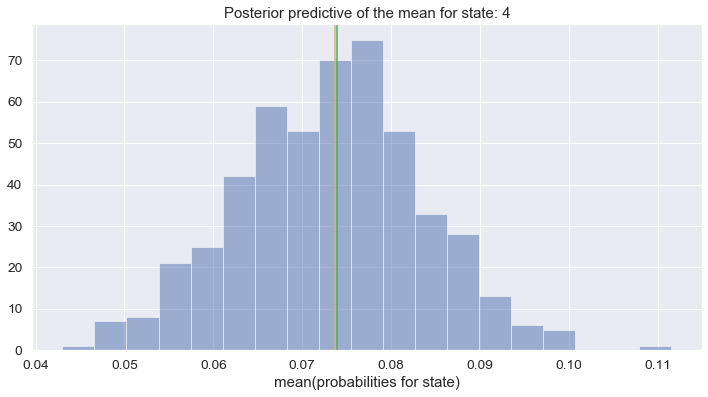

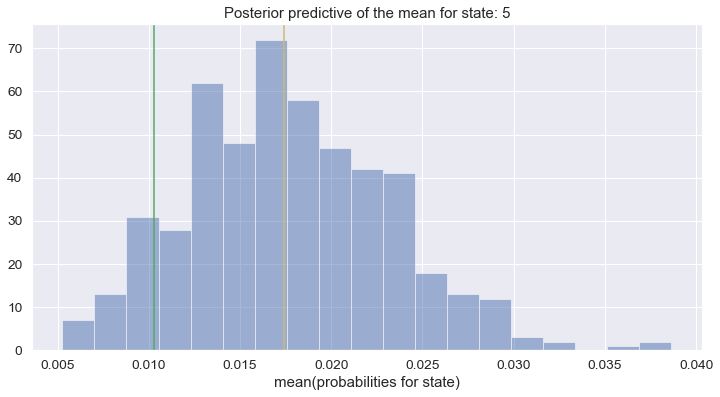

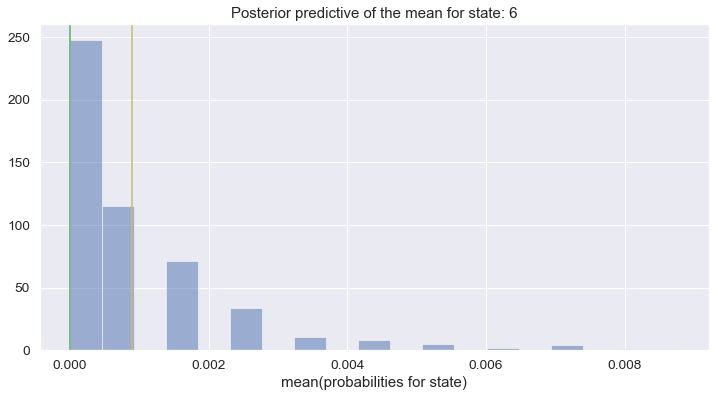

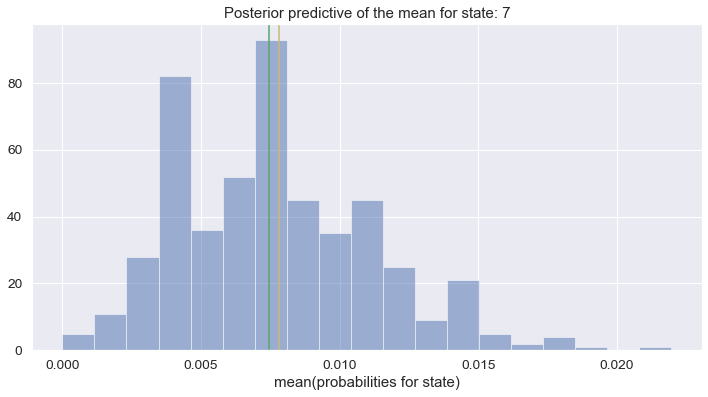

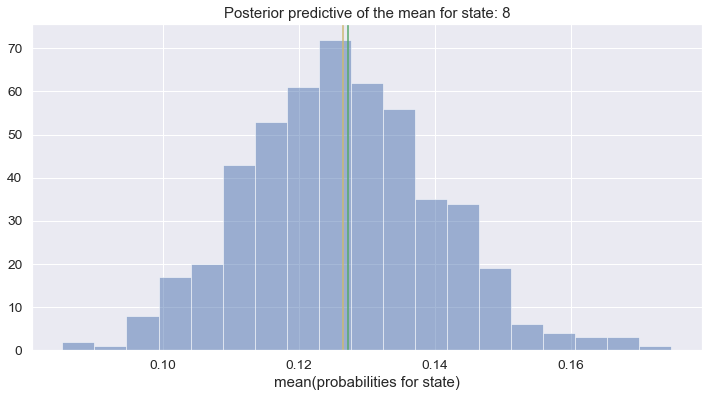

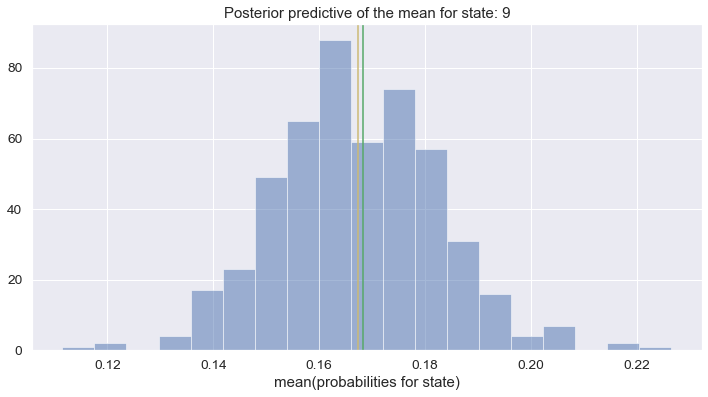

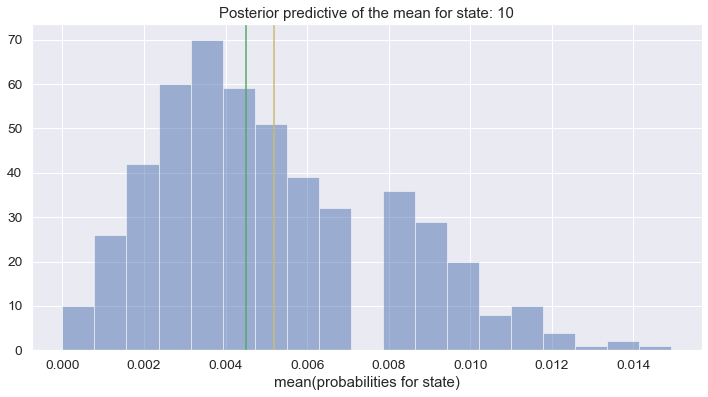

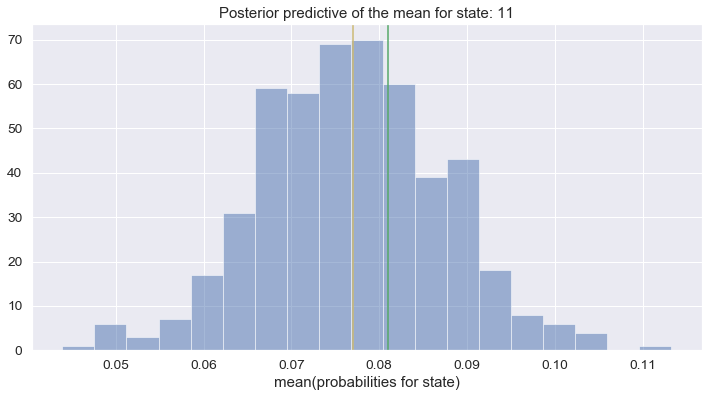

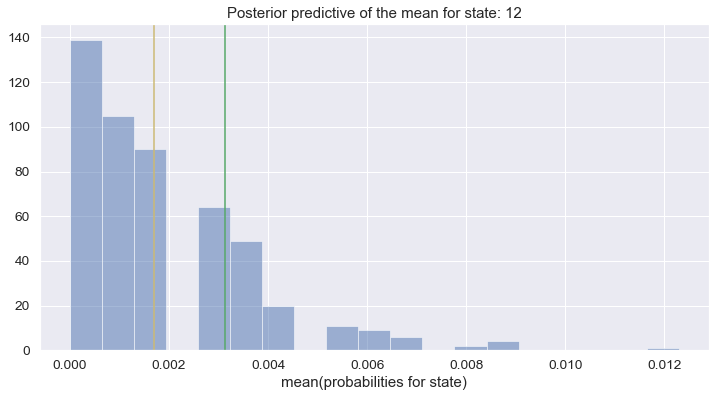

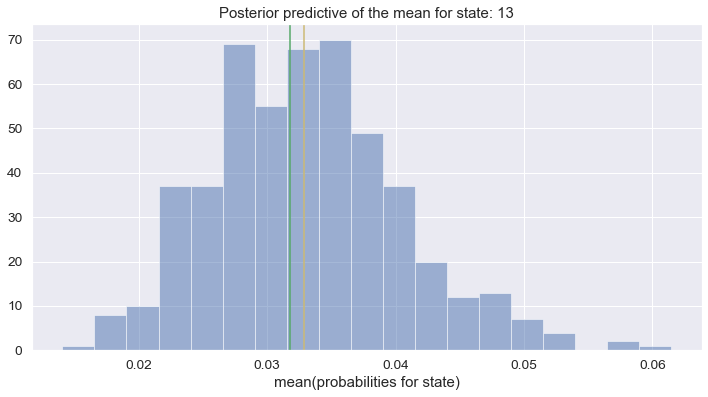

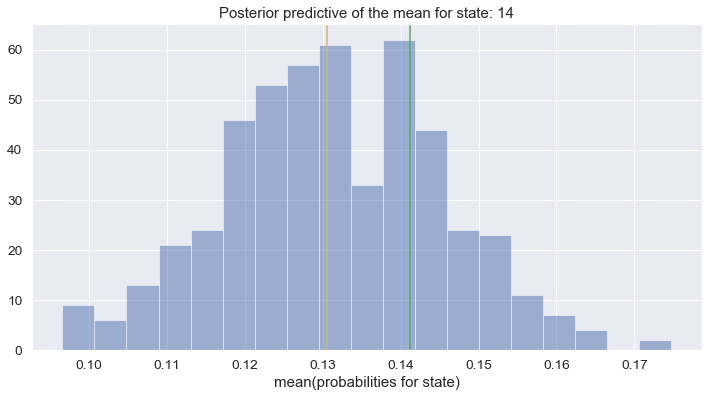

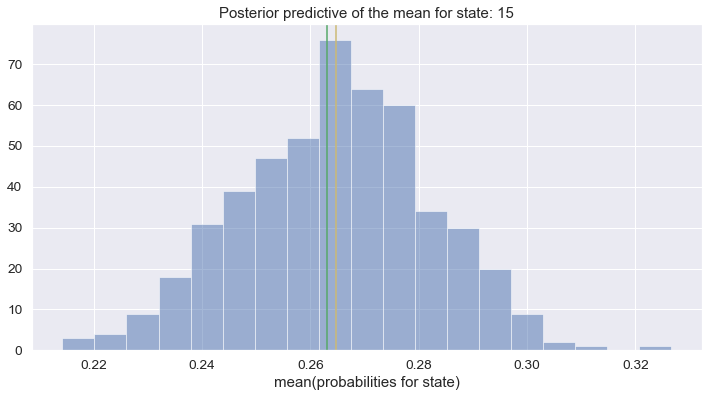

In [21]:
for i in range(16):
    tmp = ppc['results'][:, :, i]
    _, ax = plt.subplots(figsize=(12, 6))
    ax.hist([n.mean() for n in tmp], bins=19, alpha=0.5)
    ax.axvline(coh_df.iloc[i].values[0], color='g')
    ax.axvline(trace_df.loc['theta__{}'.format(i)].values[0], color='y')
    ax.set(title='Posterior predictive of the mean for state: {}'.format(i), xlabel='mean(probabilities for state)');

we can see that moel is still fitting reasonably well. 

In [22]:
ar_loo2 = az.loo(trace, pointwise=True, scale="log")
ar_loo2

Computed from 4000 by 1139 log-likelihood matrix

         Estimate       SE
elpd_loo -2405.58    26.45
p_loo       12.24        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     1138   99.9%
 (0.5, 0.7]   (ok)          1    0.1%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

we can compare previous $elpd_{loo}$ = $-2405.58$ to $-1109.77$ and $-14.94$ which shows accuracy of predicitibility declines which is as expected as there is more uncertainity for what would be next states. But from PPC we see using this technique for different values of alpha_d we can still fit the model to get estimate of coherence matrix.

In [23]:
pooled_loo = pm.loo(trace, model, pointwise=True, progressbar=True)

pooled_loo.LOO

4000it [00:02, 1875.03it/s]


4811.156678378161

In [24]:
pooled_waic = pm.waic(trace, model, pointwise=True, progressbar=True)

pooled_waic.WAIC

4000it [00:02, 1850.78it/s]
C:\Users\niraj\AppData\Local\Continuum\anaconda3\envs\probabilistic\lib\site-packages\pymc3\stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


4811.061170190332

Here we set alpha value to 0 i.e. there is no influence of social pressure. If we increase alpha value then, we get decline in estimation of coherence matrix and will effect model and fit both. However, we have not kept track of other parameter estimation from social pressure, as we do that I think it should get better.